In [1]:
import numpy as np
#from tensorflow import keras
import matplotlib
import matplotlib.pylab as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import argparse
import pandas as pd
import shap
import tensorflow as tf
tf.compat.v1.disable_v2_behavior() #without this it gives an error

from plot_shap_dl import plot_single_exp

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
IMG_SIZE = (299,299)

images_path = '../isic-data/ISIC2018_Task1-2_Training_Input/'
csv_path = '../isic-data/isic2018_T1T2.csv'
model_path = '../DL-Models-ISIC/keras_h5/iv4_t3i2018_nf.h5'
results_path = 'rn50_res/'#'pix_attr_results/'

isic18_root="../isic-data/HAM10000/ISIC2018_Task3_Training_Input/"
train_i18_csv="../DL-Models-ISIC/csv_splits/isic2018n_train.csv"


df=pd.read_csv(csv_path)
images =df.image.values
labels = df.label.values


def softmax(x):
    f = np.exp(x)/np.sum(np.exp(x), axis = 1, keepdims = True)
    return f

def load():
    df=pd.read_csv(csv_path)
    images =df.image.values
    images =[images[i][:-5] for i in range(len(images))]
    labels = df.label.values

    model = tf.keras.models.load_model(model_path)


    return images, labels, model

def preprocess_img(image_id,path):
    img_sample = Image.open(path+image_id+'.jpg')
    img = np.array(img_sample.resize(IMG_SIZE, Image.BILINEAR))
    def normalize_image(image, mean, std):
        for channel in range(3):
            image[:,:,channel] = (image[:,:,channel] - mean[channel]) / std[channel]
        return image

    n_img= normalize_image(np.array(img) / 255.0, 
                            mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225])
    
    return n_img

In [3]:
images, labels, model  = load()


2022-12-06 17:36:42.796637: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 17:36:43.406512: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 47222 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:1e:00.0, compute capability: 7.5


In [4]:
a=np.array([1,2,3,4,5,6])
b=np.array([4,5])
sorter = np.argsort(a)
sorter[np.searchsorted(a, b, sorter=sorter)]

array([3, 4])

In [191]:
used=np.array(['ISIC_0000513', 'ISIC_0011387', 'ISIC_0000003', 'ISIC_0000485','ISIC_00001358','ISIC_0000216','ISIC_0000155', 'ISIC_0010175', 'ISIC_0000155'])
sorter = np.argsort(np.array(images))
indices_n=sorter[np.searchsorted(np.array(images), used, sorter=sorter)]

In [177]:
images

['ISIC_0014795',
 'ISIC_0015216',
 'ISIC_0014931',
 'ISIC_0015568',
 'ISIC_0014792',
 'ISIC_0014836',
 'ISIC_0015412',
 'ISIC_0015124',
 'ISIC_0015008',
 'ISIC_0014746',
 'ISIC_0015276',
 'ISIC_0014803',
 'ISIC_0014940',
 'ISIC_0014854',
 'ISIC_0015089',
 'ISIC_0015482',
 'ISIC_0014863',
 'ISIC_0014952',
 'ISIC_0015050',
 'ISIC_0014833',
 'ISIC_0015403',
 'ISIC_0015130',
 'ISIC_0014787',
 'ISIC_0015244',
 'ISIC_0015009',
 'ISIC_0015202',
 'ISIC_0014832',
 'ISIC_0014769',
 'ISIC_0015264',
 'ISIC_0014830',
 'ISIC_0014805',
 'ISIC_0014782',
 'ISIC_0014728',
 'ISIC_0014982',
 'ISIC_0014883',
 'ISIC_0015118',
 'ISIC_0014876',
 'ISIC_0015401',
 'ISIC_0015237',
 'ISIC_0014913',
 'ISIC_0015215',
 'ISIC_0015311',
 'ISIC_0014848',
 'ISIC_0015206',
 'ISIC_0014725',
 'ISIC_0015193',
 'ISIC_0015447',
 'ISIC_0015046',
 'ISIC_0015232',
 'ISIC_0015171',
 'ISIC_0015226',
 'ISIC_0015020',
 'ISIC_0014869',
 'ISIC_0014753',
 'ISIC_0015212',
 'ISIC_0014948',
 'ISIC_0014975',
 'ISIC_0014779',
 'ISIC_0014915

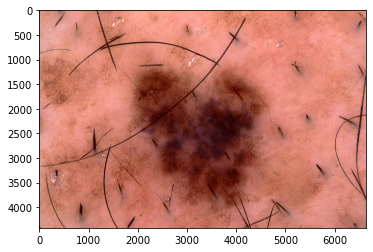

In [4]:
from matplotlib.pyplot import imshow
index = 0
img_sample = Image.open(images_path+images[index]+'.jpg')
imshow(img_sample)

In [72]:
img = np.array(img_sample.resize(IMG_SIZE, Image.BILINEAR))

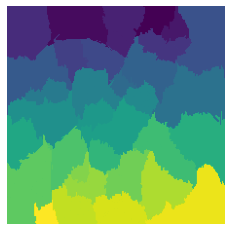

In [130]:

from skimage.segmentation import quickshift
segments_quick = quickshift(img, kernel_size=4, max_dist=200, ratio=0.2)
#SegmentationAlgorithm('quickshift', kernel_size=4,max_dist=200, ratio=0.2)

plt.imshow(segments_quick);
plt.axis('off');

In [12]:
# define a function that depends on a binary mask representing if an image region is hidden
# define a function that depends on a binary mask representing if an image region is hidden
from skimage.segmentation import quickshift
from matplotlib.pyplot import imshow
import skimage.transform as st


from matplotlib.colors import LinearSegmentedColormap
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
cm = LinearSegmentedColormap.from_list("shap", colors)

def get_shap(index):
    
    print(images[index])
    img_sample = Image.open(images_path+images[index]+'.jpg')
    img = np.array(img_sample.resize(IMG_SIZE, Image.BILINEAR))
    #imshow(img_sample)
    segments_quick = quickshift(img, kernel_size=4, max_dist=200, ratio=0.2)
    #SegmentationAlgorithm('quickshift', kernel_size=4,max_dist=200, ratio=0.2)
    
    def mask_image(zs, segmentation, image, background=None):
        if background is None:
            background = image.mean((0,1))
        out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
        for i in range(zs.shape[0]):
            out[i,:,:,:] = image
            for j in range(zs.shape[1]):
                if zs[i,j] == 0:
                    out[i][segmentation == j,:] = background
        return out


    def f(z):
        return model.predict(
            preprocess(mask_image(z, segments_quick, img, 255)))

    def preprocess(img):
        def normalize_image(image, mean, std):
            for channel in range(3):
                image[:,:,channel] = (image[:,:,channel] - mean[channel]) / std[channel]
            return image

        n_img= normalize_image(np.array(img) / 255.0, 
                                mean=[0.485, 0.456, 0.406], 
                                std=[0.229, 0.224, 0.225])

        return n_img

    def fill_segmentation(values, segmentation):
        out = np.zeros(segmentation.shape)
        for i in range(len(values)):
            out[segmentation == i] = values[i]
        return out
    
    prediction = softmax(model.predict([[preprocess(img)]]))
    cls_pred = int(prediction[0][1]>0.5)
    print(prediction, cls_pred)

    cls_true = labels[index]
    print("predicted class ids {}\t probability {} True class: {}".format(cls_pred, prediction[0][cls_pred],cls_true))


    
    explainer = shap.KernelExplainer(f, np.zeros((1,50)))
    shap_values = explainer.shap_values(np.ones((1,50)), nsamples=1000)
    
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    inds = cls_pred
    max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
    for i in range(1):
        m = fill_segmentation(shap_values[inds][0], segments_quick)#.reshape((1024,1024))
        axes.imshow(img_sample.resize((1024,1024), Image.BILINEAR).convert('LA'), alpha=0.5)
        
        axes.imshow(img_sample.resize((1024,1024), Image.BILINEAR), alpha=0.3)
        im = axes.imshow(st.resize(m, (1024, 1024)), cmap=cm, vmin=-max_val, vmax=max_val)
        axes.axis('off')
    #cb = fig.colorbar(im, ax=axes.tolist(), label="SHAP value", orientation="horizontal", aspect=60)
    #cb.outline.set_visible(False)
    
    fig.savefig('new_shap_images/iv4/'+images[index]+'_SHAP.png',dpi = fig.dpi, bbox_inches='tight')
    plt.show()

ISIC_0009883
[[0.9617803  0.03821969]] 0
predicted class ids 0	 probability 0.961780309677124 True class: 0


  0%|          | 0/1 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

FileNotFoundError: [Errno 2] No such file or directory: 'new_shap_images/iv4/ISIC_0009883_SHAP.png'

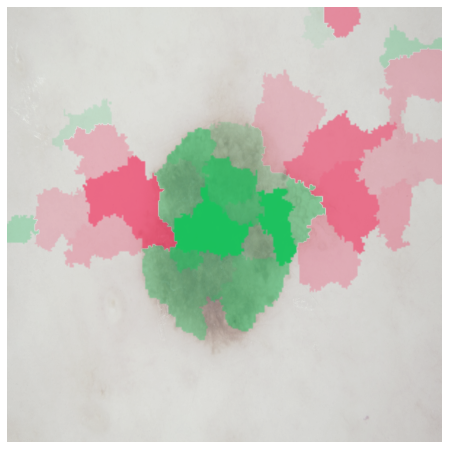

In [11]:
get_shap(660)

ISIC_0009883
[[0.9617803  0.03821969]] 0
predicted class ids 0	 probability 0.961780309677124 True class: 0


  0%|          | 0/1 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

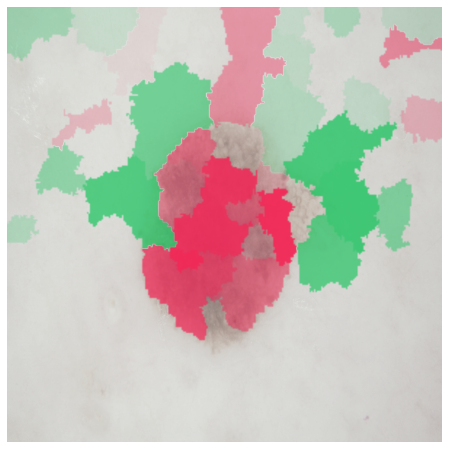

In [9]:
get_shap(660)

ISIC_0014677
[[9.999959e-01 4.101877e-06]] 0
predicted class ids 0	 probability 0.9999958872795105 True class: 0


  0%|          | 0/1 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

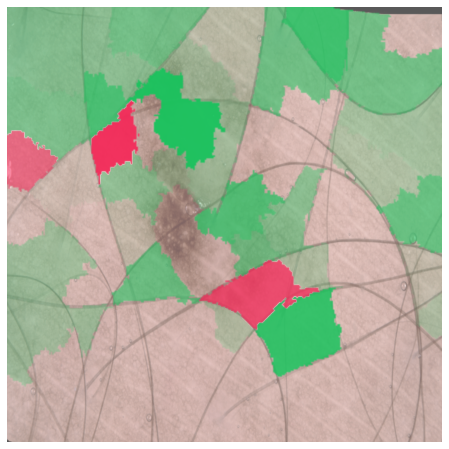

ISIC_0010013
[[9.9999976e-01 2.5416807e-07]] 0
predicted class ids 0	 probability 0.9999997615814209 True class: 0


  0%|          | 0/1 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

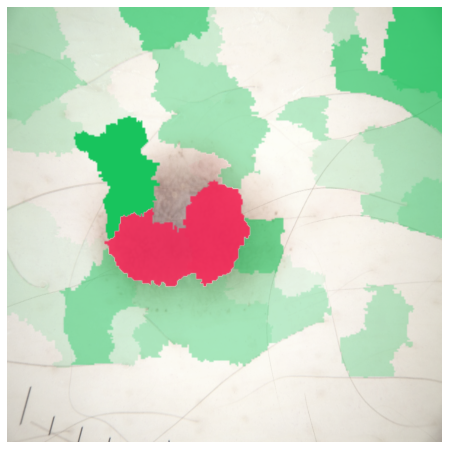

In [15]:
used=np.array(['ISIC_0014677','ISIC_0010013'])#, 'ISIC_0015071', 'ISIC_0000031', 'ISIC_0015241','ISIC_0007332','ISIC_0000218'])#,'ISIC_0013457', 'ISIC_0015256'])
sorter = np.argsort(np.array(images))
indices_n=sorter[np.searchsorted(np.array(images), used, sorter=sorter)]
for i in indices_n:
    get_shap(i)

In [82]:
prediction = softmax(model.predict([[preprocess(img)]]))
cls_pred = int(prediction[0][1]>0.5)
print(prediction, cls_pred)

cls_true = labels[index]
print("predicted class ids {}\t probability {} True class: {}".format(cls_pred, prediction[0][cls_pred],cls_true))
#model.summary()


[[9.9984401e-01 1.5598763e-04]] 0
predicted class ids 0	 probability 0.9998440146446228 True class: 0


In [88]:
shap_values[0].shape

(1, 50)

In [95]:
from matplotlib.colors import LinearSegmentedColormap
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
cm = LinearSegmentedColormap.from_list("shap", colors)

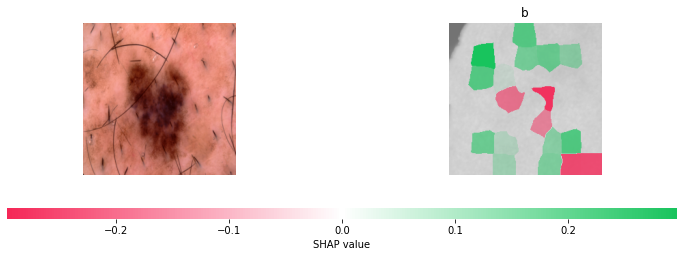

In [107]:
# plot our explanations
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
inds = cls_pred
axes[0].imshow(img)
axes[0].axis('off')
max_val = np.max([np.max(np.abs(shap_values[0][:,:-1])) for i in range(len(shap_values))])
for i in range(1):
    m = fill_segmentation(shap_values[inds][0], segments_slic)
    axes[i+1].set_title('b')
    axes[i+1].imshow(img_sample.convert('LA'), alpha=0.55)
    im = axes[i+1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
    axes[i+1].axis('off')
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
plt.show()

In [106]:
np.array(shap_values).shape

(2, 1, 50)

In [109]:
m.shape

(224, 224)

In [ ]:
import skimage.transform as st

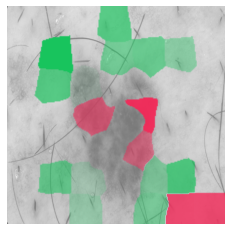

In [124]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,4))
inds = cls_pred
max_val = np.max([np.max(np.abs(shap_values[0][:,:-1])) for i in range(len(shap_values))])
for i in range(1):
    m = fill_segmentation(shap_values[inds][0], segments_slic)#.reshape((1024,1024))
    axes.imshow(img_sample.resize((1024,1024), Image.BILINEAR).convert('LA'), alpha=0.55)
    im = axes.imshow(st.resize(m, (1024, 1024)), cmap=cm, vmin=-max_val, vmax=max_val)
    axes.axis('off')
#cb = fig.colorbar(im, ax=axes.tolist(), label="SHAP value", orientation="horizontal", aspect=60)
#cb.outline.set_visible(False)
plt.show()

In [117]:
m.shape

(224, 224)

In [119]:
224*224

50176

In [122]:
m

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.23167862,
        -0.23167862, -0.23167862],
       [ 0.        ,  0.        ,  0.        , ..., -0.23167862,
        -0.23167862, -0.23167862],
       [ 0.        ,  0.        ,  0.        , ..., -0.23167862,
        -0.23167862, -0.23167862]])

In [123]:
import skimage.transform as st

In [131]:

# use Kernel SHAP to explain the network's predictions
explainer = shap.KernelExplainer(f, np.zeros((1,50)))
shap_values = explainer.shap_values(np.ones((1,50)), nsamples=1000) # runs VGG16 1000 times


  0%|          | 0/1 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

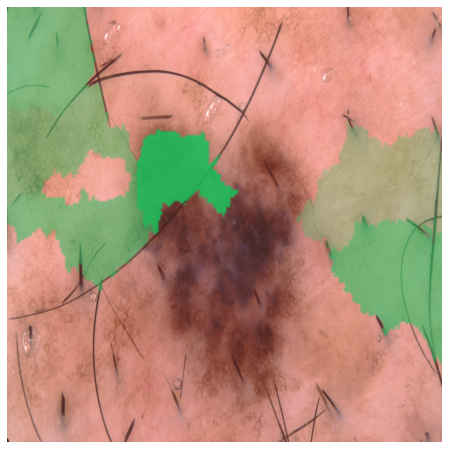

In [163]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
inds = cls_pred
max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
for i in range(1):
    m = fill_segmentation(shap_values[inds][0], segments_quick)#.reshape((1024,1024))
    axes.imshow(img_sample.resize((1024,1024), Image.BILINEAR), alpha=0.85)
    im = axes.imshow(st.resize(m, (1024, 1024)), cmap=cm, vmin=-max_val, vmax=max_val,  alpha=0.85)
    axes.axis('off')
#cb = fig.colorbar(im, ax=axes.tolist(), label="SHAP value", orientation="horizontal", aspect=60)
#cb.outline.set_visible(False)

fig.savefig('test_shap.png',dpi = fig.dpi, bbox_inches='tight')
plt.show()

In [137]:
m[0]

array([ 0.09480755,  0.09480755,  0.09480755,  0.09480755,  0.09480755,
        0.09480755,  0.09480755,  0.09480755,  0.09480755,  0.09480755,
        0.09480755,  0.09480755,  0.09480755,  0.09480755,  0.09480755,
        0.09480755,  0.09480755,  0.09480755,  0.09480755,  0.09480755,
        0.09480755,  0.09480755,  0.09480755,  0.09480755,  0.09480755,
        0.09480755,  0.09480755,  0.09480755,  0.09480755,  0.09480755,
        0.09480755,  0.09480755,  0.09480755,  0.09480755,  0.09480755,
        0.09480755,  0.09480755,  0.09480755,  0.09480755,  0.09480755,
        0.09480755, -0.01072981, -0.01072981, -0.01072981, -0.01072981,
       -0.01072981, -0.01072981, -0.01072981, -0.01072981, -0.01072981,
       -0.01072981, -0.01072981, -0.01072981, -0.01072981, -0.01072981,
       -0.01072981, -0.01072981, -0.01072981, -0.01072981, -0.01072981,
       -0.01072981, -0.01072981, -0.01072981, -0.01072981, -0.01072981,
       -0.01072981, -0.01072981, -0.01072981, -0.01072981, -0.01

In [140]:
shap_values[0]

array([[ 0.        , -0.01072981,  0.        ,  0.        ,  0.09480755,
         0.        ,  0.        ,  0.        ,  0.        ,  0.07834444,
         0.        ,  0.        ,  0.05193936,  0.        ,  0.16037341,
         0.        ,  0.09417438,  0.        ,  0.        ,  0.        ,
         0.10596236,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.03624196,
         0.        ,  0.        ,  0.05534893,  0.11569544,  0.00382218,
        -0.0120497 ,  0.        ,  0.01597642,  0.        ,  0.        ,
         0.07901818,  0.        ,  0.        ,  0.        ,  0.        ]])